<a href="https://colab.research.google.com/github/ShinAsakawa/ShinAsakawa.github.io/blob/master/2022notebooks/2022_1010lam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAM モデル

- lam とは Lexical, auditoral, and motoral の頭文字
- Walker and Hickok (2016) の SLAM モデルから S を除いた意味


In [7]:
!rm -rf ccap

In [ ]:
# このセルはお遊びなので，スキップしても良い
import IPython
IPython.display.Image(url="https://livedoor.blogimg.jp/ftb001/imgs/b/4/b4629a79.jpg")

In [1]:
%config InlineBackend.figure_format = 'retina'
try:
    import bit
except ImportError:
    !pip install ipynbname --upgrade > /dev/null 2>&1 
    !git clone https://github.com/ShinAsakawa/bit.git
import bit
#from a_utils import *
isColab = bit.isColab
HOME = bit.HOME

日付: 2022-10-10
HOSTNAME: 361f6becbfd3
ユーザ名: root
HOME: /root
ファイル名: /fileId=17Az8bJiF4173Fu00kWPfw6Y65-rr1A63
torch.__version__: 1.12.1+cu113


In [16]:
!ls -lt ccap

total 29540
-rw-r--r-- 1 root root 28676840 Oct 10 05:35  psylex71utf8.txt
drwxr-xr-x 2 root root     4096 Oct 10 04:34  __pycache__
-rw-r--r-- 1 root root    65698 Oct 10 04:34 '呼称(TLPA)語彙属性.xlsx'
-rw-r--r-- 1 root root   238086 Oct 10 04:34  onomatopea.dic
-rw-r--r-- 1 root root    11627 Oct 10 04:34  tlpa_o2p.py
-rw-r--r-- 1 root root     5811 Oct 10 04:34  tsne.py
-rw-r--r-- 1 root root     4790 Oct 10 04:34  vdj2500.py
-rw-r--r-- 1 root root    50900 Oct 10 04:34  onomatope.py
drwxr-xr-x 4 root root     4096 Oct 10 04:34  data
-rw-r--r-- 1 root root     1126 Oct 10 04:34  mecab_settings.py
-rw-r--r-- 1 root root     7916 Oct 10 04:34  minnichi.py
-rw-r--r-- 1 root root    28413 Oct 10 04:34  multi_modal.py
drwxr-xr-x 2 root root     4096 Oct 10 04:34  notebooks
-rw-r--r-- 1 root root    47050 Oct 10 04:34  2022_0515minnchi_sents.txt
-rw-r--r-- 1 root root     7678 Oct 10 04:34  ccap_normalize_neologd.py
-rw-r--r-- 1 root root    23360 Oct 10 04:34  ccap.py
-rw-r--r-- 1 root root  

In [10]:
from google.colab import files
uploaded = files.upload()  # lam.py, psylex71utf8.txt のアップロード

Saving psylex71utf8.txt to psylex71utf8.txt


In [17]:
#!mv psylex71utf8.txt ccap
#!ls -lt ccap
!cp ccap/*.xlsx .

In [2]:
import torch
import torch.nn
import torch.optim

import os
import sys
import typing
import numpy as np
import copy
from termcolor import colored

# from tqdm import tqdm         #commandline で実行時
from tqdm.notebook import tqdm  #jupyter で実行時

import random

try:
    import ccap
except ImportError:
    !git clone https://github.com/ShinAsakawa/ccap.git
    import ccap

# ローカルと colab との相違を吸収するために
# 本ファイルを Google Colaboratory 上で実行する場合に，必要となるライブラリをインストール
if isColab:
    !pip install japanize_matplotlib > /dev/null 2>&1
    !pip install jaconv > /dev/null 2>&1

    # MeCab, fugashi, ipadic のインストール
    !apt install aptitude swig > /dev/null 2>&1
    !aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y > /dev/null 2>&1
    !pip install mecab-python3==0.7 > /dev/null 2>&1
    !pip install --upgrade ipadic > /dev/null 2>&1

    #!sudo apt update -qy && apt install -qy mecab libmecab-dev mecab-ipadic-utf8
    !pip install -q konoha[all]
    !pip install japanize_matplotlib > /dev/null 2>&1    

Cloning into 'ccap'...
remote: Enumerating objects: 841, done.
remote: Counting objects: 100% (261/261), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 841 (delta 141), reused 254 (delta 138), pack-reused 580
Receiving objects: 100% (841/841), 31.75 MiB | 21.01 MiB/s, done.
Resolving deltas: 100% (167/167), done.


In [3]:
%load_ext autoreload
%autoreload 2
import lam # 自作ライブラリ LAM の読み込み
from lam import EncoderRNN
from lam import AttnDecoderRNN
from lam import convert_ids2tensor
from lam import train
from lam import asMinutes, timeSince
#from lam import fit
from lam import convert_ids2tensor
from lam import fix_seed
from lam import worker_init_fn
from lam import make_vocab_dataset

# シミュレーションに必要なパラメータの設定
params = {
    'traindata_size': 10000,     # 訓練データ数，NTT 日本語語彙特性の高頻度語を上位から抽出
    'epochs': 20,                # 学習のためのエポック数
    'hidden_size': 24,           # 中間層のニューロン数
    'random_seed': 42,           # 乱数の種。ダグラス・アダムス著「銀河ヒッチハイカーズガイド」

    # 以下 `source` と `target` を定義することで，別の課題を実行可能
    'source': 'mora_p',        # ['orthography', 'phonology', 'mora', 'mora_p', 'mora_p_r']
    'target': 'mora_p',          # ['orthography', 'phonology', 'mora', 'mora_p', 'mora_p_r']
    # 'orthography': 書記素, 
    # 'phonology': 音韻, 
    # 'mora': モーラ
    # 'mora_p': モーラを silius による音分解
    # 'mora_p_r': モーラの silius 音分解の逆
    'pretrained': True,          # True であれば訓練済ファイルを読み込む
    'isTrain'   : True,          # True であれば学習する
    
    # 学習済のモデルパラメータを保存するファイル名
    #'path_saved': '2022_0607lam_o2p_hid32_vocab10k.pt', 
    'path_saved': '2022_0829lam_p2p_hid24_vocab10k.pt',
    #'path_saved': False,                      # 保存しない場合
    
    # 結果の散布図を保存するファイル名    
    'path_graph': '2022_0829lam_p2p_hid24_vocab10k.pdf',
    #'path_graph': False,                      # 保存しない場合

    'lr': 0.001,                              # 学習率
    'dropout_p': 0.0,                         # ドロップアウト率
    'teacher_forcing_ratio': 0.5,             # 教師強制を行う確率
    'optim_func': torch.optim.Adam,           # 最適化アルゴリズム ['torch.optim.Adam', 'torch.optim.SGD', 'torch.optim.AdamW']
    'loss_func' :torch.nn.CrossEntropyLoss(), # 交差エントロピー損失 ['torch.nn.NLLLoss()', or 'torch.nn.CrossEntropyLoss()']
}

device = lam.device  # CPU or GPU の選択

for param in params:
    print(colored(f'{param}','blue',attrs=['bold']), colored(f': {params[param]}','grey'))
    
# 乱数シード固定（再現性担保のため）
fix_seed(seed = params['random_seed'])
print(worker_init_fn(1))    

traindata_size : 10000
epochs : 20
hidden_size : 24
random_seed : 42
source : mora_p
target : mora_p
pretrained : True
isTrain : True
path_saved : 2022_0829lam_p2p_hid24_vocab10k.pt
path_graph : 2022_0829lam_p2p_hid24_vocab10k.pdf
lr : 0.001
dropout_p : 0.0
teacher_forcing_ratio : 0.5
optim_func : <class 'torch.optim.adam.Adam'>
loss_func : CrossEntropyLoss()
None


In [8]:
from ccap import ccap_w2v
w2v = ccap_w2v().w2v

#_vocab = lam.VOCAB(traindata_size=params['traindata_size'], w2v=w2v)

In [18]:
_vocab = lam.VOCAB(traindata_size=params['traindata_size'], w2v=w2v)
print(colored(f'訓練データサイズ:{len(_vocab.train_data)} 語。NTT 日本語語彙特性の頻度上位 {len(_vocab.train_data)} 語','blue',attrs=['bold']))
print(colored(f'音素数:{len(_vocab.phone_vocab)}','blue',attrs=['bold']))
print(colored(f'書記素数:{len(_vocab.ortho_vocab)}','blue',attrs=['bold']))
print(colored(f'最長書記素(文字)数:{_vocab.max_ortho_length}, 最長音素数:{_vocab.max_phone_length}', 'blue',attrs=['bold']))

_max_len = _vocab.max_ortho_length
_max_len = _max_len if _max_len > _vocab.max_phone_length else _vocab.max_phone_length
_max_len = _max_len if _max_len > _vocab.max_mora_length else _vocab.max_mora_length
_max_len = _max_len if _max_len > _vocab.max_mora_p_length else _vocab.max_mora_p_length
_vocab.max_length = _max_len + 1
print(colored(f'_vocab.max_length: {_vocab.max_length}', 'blue', attrs=['bold']))

# encoder と decoder の vocab を設定
source = params['source']
target = params['target']
source_vocab, \
source_ids, \
target_vocab, \
target_ids = lam.get_soure_and_target_from_params(params=params,\
                                                  _vocab=_vocab,\
                                                  source=source,\
                                                  target=target)

print(colored(f'source:{source}','blue', attrs=['bold']), f'{source_vocab}')
print(colored(f'target:{target}','cyan', attrs=['bold']), f'{target_vocab}')
print(colored(f'source_ids:{source_ids}','blue', attrs=['bold']), f'{source_ids}')
print(colored(f'target_ids:{target_ids}','cyan', attrs=['bold']), f'{target_ids}')

tlpa_nameing_data = lam.get_tlpa_naming_vocab(ntt_freq=_vocab.ntt_freq,\
                                              ntt_orth2hira=_vocab.ntt_orth2hira,\
                                              w2v=_vocab.w2v)
sala_nameing_data = lam.get_sala_naming_vocab(ntt_freq=_vocab.ntt_freq, 
                                              ntt_orth2hira=_vocab.ntt_orth2hira)
tlpa1, tlpa2, tlpa3, tlpa4, \
sala_r29, sala_r30, sala_r31 = lam.read_json_tlpa1234_sala_r29_30_31()

_dataset = {}
_data_names = ['tlpa2', 'tlpa3', 'tlpa4', 'sala_r29', 'sala_r30', 'sala_r31']
for data in _data_names:
    _dataset[data] = {'rawdata':eval(data),
                      'pdata': lam.make_vocab_dataset(eval(data),vocab=_vocab)}

# 以下は後から付け足したので，コードが汚くなっている。
# 時間ができたらコードの整理をすること
X_vals = lam.make_X_vals(_dataset=_dataset,
                         source_vocab=source_vocab,
                         target_vocab=target_vocab)

# NTT日本語語彙特性 (天野，近藤; 1999, 三省堂)より頻度情報を取得
# 訓練に用いる単語の選定 10000 語


  0%|          | 0/10000 [00:00<?, ?it/s]

訓練データサイズ:9934 語。NTT 日本語語彙特性の頻度上位 9934 語
音素数:47
書記素数:1838
最長書記素(文字)数:11, 最長音素数:28
_vocab.max_length: 31
source:mora_p ['<PAD>', '<EOW>', '<SOW>', '<UNK>', 'N', 'a', 'b', 'by', 'ch', 'd', 'dy', 'e', 'f', 'g', 'gy', 'h', 'hy', 'i', 'j', 'k', 'ky', 'm', 'my', 'n', 'ny', 'o', 'p', 'py', 'q', 'r', 'ry', 's', 'sh', 't', 'ts', 'u', 'w', 'y', 'z']
target:mora_p ['<PAD>', '<EOW>', '<SOW>', '<UNK>', 'N', 'a', 'b', 'by', 'ch', 'd', 'dy', 'e', 'f', 'g', 'gy', 'h', 'hy', 'i', 'j', 'k', 'ky', 'm', 'my', 'n', 'ny', 'o', 'p', 'py', 'q', 'r', 'ry', 's', 'sh', 't', 'ts', 'u', 'w', 'y', 'z']
source_ids:mora_p_ids mora_p_ids
target_ids:mora_p_ids mora_p_ids
source:mora_p ['<PAD>', '<EOW>', '<SOW>', '<UNK>', 'N', 'a', 'b', 'by', 'ch', 'd', 'dy', 'e', 'f', 'g', 'gy', 'h', 'hy', 'i', 'j', 'k', 'ky', 'm', 'my', 'n', 'ny', 'o', 'p', 'py', 'q', 'r', 'ry', 's', 'sh', 't', 'ts', 'u', 'w', 'y', 'z']
target:mora_p ['<PAD>', '<EOW>', '<SOW>', '<UNK>', 'N', 'a', 'b', 'by', 'ch', 'd', 'dy', 'e', 'f', 'g', 'gy', 'h', 'h

FileNotFoundError: ignored

In [7]:
from ccap import ccap_w2v
x = ccap_w2v().w2v

# 以前に保存したモデルがある場合には，そのパラメータを読み込む


In [15]:
import MeCab

wakati = MeCab.Tagger('-Owakati').parse
wakati('以前に保存したモデルがある場合には，そのパラメータを読み込む')

'以前 に 保存 し た モデル が ある 場合 に は ， その パラメータ を 読み込む \n'

In [ ]:
from lam import calc_accuracy

if (params['pretrained']) and (params['path_saved'] != False) and os.path.exists(params['path_saved']):
    """セーブした学習済のモデルがあれば読み込む"""
    
    checkpoint = torch.load(params['path_saved'])
    encoder = EncoderRNN(len(source_vocab), params['hidden_size']).to(device)
    decoder = AttnDecoderRNN(n_hid=params['hidden_size'], 
                             n_out=len(target_vocab), 
                             dropout_p=params['dropout_p'],
                             max_length=_vocab.max_length).to(device)
    encoder.load_state_dict(checkpoint['encoder'])
    decoder.load_state_dict(checkpoint['decoder'])
    encoder.eval()
    decoder.eval()
    losses = []
    
    encoder2 = EncoderRNN(len(target_vocab), params['hidden_size']).to(device)
    decoder2 = AttnDecoderRNN(n_hid=params['hidden_size'], 
                              n_out=len(target_vocab), 
                              dropout_p=params['dropout_p'],
                              max_length=_vocab.max_length).to(device)
    encoder2.load_state_dict(checkpoint['encoder'])
    decoder2.load_state_dict(checkpoint['decoder'])
    encoder2.eval()
    decoder2.eval()
    
    print(colored(f"セーブした学習済のモデル {params['path_saved']} があるので読み込みました",
          color='blue', attrs=['bold']))
    # print(encoder)
    # print(decoder)
    # print(encoder2)
    # print(decoder2)

else:
    encoder = EncoderRNN(len(source_vocab), params['hidden_size']).to(device)
    decoder = AttnDecoderRNN(n_hid=params['hidden_size'], 
                             n_out=len(target_vocab), 
                             dropout_p=params['dropout_p'],
                             max_length=_vocab.max_length
                            ).to(device)

# モデルの概要を印字
print(f'encoder:{encoder}')
print(f'decoder:{decoder}')
_param = {}
for _model in ['encoder', 'decoder']:
    _param[_model] = {}
    for __name, __param in eval(_model).named_parameters():
        _param[_model][__name] = __param.detach().numpy()

for _model, _val in _param.items():
    print(colored(f'{_model}','red', attrs=['bold']))
    for w_name, w_val in _param[_model].items():
        print((w_name, _param[_model][w_name].shape, w_val.dtype)) #_param[model][)) # (k,_k))
        
for test_name, val_dataset in X_vals.items():
    acc = calc_accuracy(_dataset=val_dataset,
                        encoder=encoder,
                        decoder=decoder,
                        #decoder=decoder2,
                        max_length=_vocab.max_length,
                        source_vocab=source_vocab,
                        target_vocab=target_vocab)
    print(colored(f'{test_name} の精度:{acc:.3f}','blue', attrs=['bold']))


# params の印刷
print(colored(params,'blue',attrs=['bold']))    

セーブした学習済のモデル 2022_0829lam_p2p_hid24_vocab10k.pt があるので読み込みました
encoder:EncoderRNN(
  (embedding): Embedding(39, 24)
  (gru): GRU(24, 24)
)
decoder:AttnDecoderRNN(
  (embedding): Embedding(39, 24)
  (attn): Linear(in_features=48, out_features=31, bias=True)
  (attn_combine): Linear(in_features=48, out_features=24, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (gru): GRU(24, 24)
  (out): Linear(in_features=24, out_features=39, bias=True)
)
encoder
('embedding.weight', (39, 24), dtype('float32'))
('gru.weight_ih_l0', (72, 24), dtype('float32'))
('gru.weight_hh_l0', (72, 24), dtype('float32'))
('gru.bias_ih_l0', (72,), dtype('float32'))
('gru.bias_hh_l0', (72,), dtype('float32'))
decoder
('embedding.weight', (39, 24), dtype('float32'))
('attn.weight', (31, 48), dtype('float32'))
('attn.bias', (31,), dtype('float32'))
('attn_combine.weight', (24, 48), dtype('float32'))
('attn_combine.bias', (24,), dtype('float32'))
('gru.weight_ih_l0', (72, 24), dtype('float32'))
('gru.weight_hh_l0'

# 学習の実施

In [ ]:
# 訓練データセットと検証データセットを作成
train_dataset = lam.Train_dataset(data=_vocab.train_data, 
                                  source_vocab=source_vocab, 
                                  target_vocab=target_vocab)

val_dataset = lam.Val_dataset(data=_dataset['sala_r29']['pdata'],
                               source_vocab=source_vocab, 
                               target_vocab=target_vocab)


In [ ]:
params['isTrain'] = False
params['epochs'] = 0
print(params['epochs'])
print(params['path_saved'])

0
2022_0829lam_p2p_hid24_vocab10k.pt


In [ ]:
%%time
if params['isTrain']:
    losses = []
    losses = losses + lam.fit(encoder, decoder, 
                              device=device,
                              epochs=params['epochs'], 
                              max_length=_vocab.max_length,
                              n_sample=0,
                              params=params,
                              source_vocab=source_vocab,
                              target_vocab=target_vocab,
                              teacher_forcing_ratio=params['teacher_forcing_ratio'],
                              train_dataset=train_dataset,
                              #val_dataset=val_dataset,
                              val_dataset=X_vals,
                             )

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


In [ ]:
params['epochs'] = 0
params['epochs']

0

In [ ]:
# 直上セルではうまく動作しないが，このセルなら上手くいく
# 違いは，val_datset=val_dataset 引数の有無のみである。
losses = losses + lam.fit(encoder, decoder, 
                          device=device,
                          epochs=params['epochs'], 
                          max_length=_vocab.max_length,
                          n_sample=0,
                          params=params,
                          source_vocab=source_vocab,
                          target_vocab=target_vocab,
                          teacher_forcing_ratio=params['teacher_forcing_ratio'],
                          train_dataset=train_dataset,
                         )

In [ ]:
print(f'params["path_saved"]:{params["path_saved"]}')

params["path_saved"]:2022_0829lam_p2p_hid24_vocab10k.pt


In [ ]:
if os.path.exists(params['path_saved']):
    print(f'ファイル:{params["path_saved"]} が存在します。上書きしますか?')
    yesno = input('y/N')
    yesno = True if yesno == 'y' else False
    torch.save({'encoder':encoder.state_dict(),
                'decoder':decoder.state_dict()}, params['path_saved'])
else:
    torch.save({'encoder':encoder.state_dict(),
                'decoder':decoder.state_dict()}, params['path_saved'])    

ファイル:2022_0829lam_p2p_hid24_vocab10k.pt が存在します。上書きしますか?


y/N n


In [ ]:
train_dataset.__getitem__(1)
train_dataset.convert_source_ids_to_tokens([25,1])

['o', '<EOW>']

In [ ]:
#losses = losses + fit(encoder, decoder, epochs=10, n_sample=0)

In [ ]:
try:
    import jaconv
except ImportError:
    !pip install jaconv
    import jaconv

def evaluate_free_input(encoder:torch.nn.Module, 
                        decoder:torch.nn.Module,
                        inp=None,
                       )->None:
    if inp == None:
        inp = input()
    inp = jaconv.normalize(inp)
    inputs = lam.tokenize(inp, pad=False,max_length=_vocab.max_length, _vocab=source_vocab)
    input_ids = inputs # ['input_ids']
    output_tokens, output_words, attentions = lam.evaluate(encoder, 
                                                           decoder, 
                                                           input_ids,
                                                           max_length=_vocab.max_length,
                                                           source_vocab=source_vocab,
                                                           target_vocab=target_vocab)
    
    #output_tokens, output_words, attentions = evaluate(encoder, decoder, input_ids)
    #output_ids = val_dataset.convert_phone_ids_to_tokens(output_tokens)
    output_ids = output_tokens
    return input_ids, output_ids


In [ ]:
print(lam.tokenize('neko', _vocab=source_vocab, max_length=_vocab.max_length))
tokens = lam.tokenize('neko', _vocab=source_vocab, max_length=_vocab.max_length)


[23, 11, 19, 25]


In [ ]:
#inp, out = evaluate_free_input(encoder,decoder, inp='kone')
#inp, out = evaluate_free_input(encoder,decoder, inp='neko')
#inp, out = evaluate_free_input(encoder,decoder, inp='aiueo')
#inp, out = evaluate_free_input(encoder,decoder, inp='sae')
#inp, out = evaluate_free_input(encoder,decoder, inp='esa')
#inp, out = evaluate_free_input(encoder,decoder, inp='nomobeta')
#inp, out = lam.evaluate_free_input(encoder,decoder, inp='kone')
#inp, out = evaluate_free_input(encoder,decoder, inp='iseruu')
#inp, out = evaluate_free_input(encoder,decoder, inp='ratuya')
#inp, out = evaluate_free_input(encoder,decoder, inp='rato')
#inp, out = evaluate_free_input(encoder,decoder, inp='toto')
#print(val_dataset.convert_source_ids_to_tokens(inp))

for _inp in ['too', 'eko']:
    inp, out = evaluate_free_input(encoder,decoder, inp=_inp)
    print(f"inp:{X_vals['tlpa4val'].convert_source_ids_to_tokens(inp)}")
    print(f'out:{out}')
    

inp:['t', 'o', 'o']
out:['e', 't', 'o', '<EOW>']
inp:['e', 'k', 'o']
out:['k', 'i', 'e', '<EOW>']


'suika' -> 'k','a', 'i', 's', 'u'

In [ ]:
inp_ = ''.join(_dataset['sala_r29']['pdata'][0]['mora_p_r'])
#inp_ = ''.join(_dataset['sala_r29']['pdata'][0]['mora_p'])
inp, out = evaluate_free_input(encoder, decoder, inp=inp_)
print(val_dataset.convert_source_ids_to_tokens(inp))
print(out)

['b', 'i', 'r', 'e', 't', 'e']
['t', 'e', '<EOW>']


In [ ]:
#_dataset['tlpa2'].keys()
print(_dataset['tlpa2']['rawdata']) #['Cond'])
#print(_dataset['sala_r31']['Cond'].keys())
#type(X_vals['TLPA2'])

{'01': ['こより', ''], '02': ['よもい', '（よろい）'], '03': ['ゆのみ', ''], '04': ['たきぎ', ''], '05': ['あつび', '（あくび）'], '06': ['けむに', ' (けむり)'], '07': ['わらじ', ''], '08': ['いとろ', '（いとこ）'], '09': ['みきん', '（みりん）'], '10': ['なだけ', '（なだれ）'], '11': ['かがみ', ''], '12': ['もさか', '（とさか）'], '13': ['あくび', ''], '14': ['よぶし', '（こぶし）'], '15': ['たがみ', '（かがみ）'], '16': ['あらし', ''], '17': ['みりん', ''], '18': ['とさか', ''], '19': ['わぶと', '（かぶと）'], '20': ['けむり', ''], '21': ['あまし', '（あらし）'], '22': ['うどん', ''], '23': ['こよち', '（こより）'], '24': ['のれん', ''], '25': ['むしろ', ''], '26': ['やぶら', '（やぐら）'], '27': ['なだれ', ''], '28': ['うごん', ' (うどん)'], '29': ['たきり', ' (たきぎ)'], '30': ['いとこ', ''], '31': ['うちわ', ''], '32': ['たらじ', '（わらじ）'], '33': ['くのみ', '（ゆのみ）'], '34': ['ゆしろ', '（むしろ）'], '35': ['かぶと', ''], '36': ['こぶし', ''], '37': ['よろい', ''], '38': ['うちな', '（うちわ）'], '39': ['やぐら', ''], '40': ['のけん', '（のれん）']}


In [ ]:
from lam import calc_val_tlpas
from lam import calc_val_salas

print([(k,type(_dataset[k])) for k in _dataset.keys()])
print([(k,type(X_vals[k])) for k in X_vals.keys()])
#_dataset['tlpa2']

[('tlpa2', <class 'dict'>), ('tlpa3', <class 'dict'>), ('tlpa4', <class 'dict'>), ('sala_r29', <class 'dict'>), ('sala_r30', <class 'dict'>), ('sala_r31', <class 'dict'>)]
[('sala_r29val', <class 'lam.lam.Val_dataset'>), ('sala_r30val', <class 'lam.lam.Val_dataset'>), ('sala_r31val', <class 'lam.lam.Val_dataset'>), ('tlpa2val', <class 'lam.lam.Val_dataset'>), ('tlpa3val', <class 'lam.lam.Val_dataset'>), ('tlpa4val', <class 'lam.lam.Val_dataset'>)]


In [ ]:
def dup_lam_model(src_encoder=encoder, src_decoder=decoder, params=params,
                  source_vocab=source_vocab, target_vocab=target_vocab,
                  max_length=_vocab.max_length):
    dst_encoder = EncoderRNN(len(source_vocab), params['hidden_size'])
    dst_decoder = AttnDecoderRNN(n_hid=params['hidden_size'], 
                                 n_out=len(target_vocab), 
                                 dropout_p=params['dropout_p'],
                                 max_length=_vocab.max_length)
    #ret_params = get_lam_params()
    dst_encoder.load_state_dict(copy.deepcopy(src_encoder.state_dict()))
    dst_decoder.load_state_dict(copy.deepcopy(src_decoder.state_dict()))

    return dst_encoder, dst_decoder

def get_lam_params(encoder=encoder, decoder=decoder):
    
    def deep_copy_model(model):
        _params_dict = {}
        for name, param in model.named_parameters():
            _params_dict[name] = copy.deepcopy(param.detach())
        return _params_dict
    
    _enc = deep_copy_model(encoder)
    _dec = deep_copy_model(decoder)
    return {'encoder':_enc, 'decoder':_dec}
            
lam_params = get_lam_params()
enc2, dec2 = dup_lam_model(src_encoder=encoder,src_decoder=decoder)

isPrint = False
steps = 20
tlpa_results, sala_results = {}, {}
for step in range(steps+1):
    _factor = (steps - step)/steps
    if isPrint: print(colored(f'崩壊率:{(1-_factor):.2f}',color='cyan', attrs=['bold']))
    
    #dec2.attn.weight.data      = copy.deepcopy(lam_params['decoder']['attn.weight']      * _factor)
    #dec2.gru.weight_hh_l0.data = copy.deepcopy(lam_params['decoder']['gru.weight_hh_l0'] * _factor)
    dec2.gru.weight_ih_l0.data = copy.deepcopy(lam_params['decoder']['gru.weight_ih_l0'] * _factor)
    
    if isPrint:
        calc_val_tlpas(encoder=encoder, decoder=dec2,
                       source_vocab=source_vocab, target_vocab=target_vocab, 
                       max_length=_vocab.max_length,
                       _dataset=_dataset, X_vals=X_vals, isPrint=isPrint)
        calc_val_salas(encoder=encoder, decoder=dec2, isPrint=isPrint)
    else:
        __factor = str(f'{_factor:.2f}')
        tlpa_results[__factor] = lam.calc_val_tlpas(encoder=encoder, decoder=dec2, 
                                                    source_vocab=source_vocab, target_vocab=target_vocab, 
                                                    max_length=_vocab.max_length,
                                                    _dataset=_dataset, 
                                                    X_vals=X_vals, 
                                                    isPrint=isPrint)
        sala_results[__factor] = lam.calc_val_salas(encoder=encoder, decoder=dec2, 
                                                    source_vocab=source_vocab, 
                                                    target_vocab=target_vocab, 
                                                    max_length=_vocab.max_length,
                                                    _dataset=_dataset,
                                                    X_vals=X_vals,
                                                    isPrint=isPrint)
        

for test in ['sala_r29', 'sala_r30', 'sala_r31']:
    print(colored(test, 'blue', attrs=['bold']))
    for k, v in sala_results.items():
        print(k,v[test])        

sala_r29
1.00 {'HH': 1.0, 'HL': 1.0, 'LH': 1.0, 'LL': 1.0}
0.95 {'HH': 1.0, 'HL': 1.0, 'LH': 1.0, 'LL': 1.0}
0.90 {'HH': 1.0, 'HL': 1.0, 'LH': 1.0, 'LL': 1.0}
0.85 {'HH': 1.0, 'HL': 1.0, 'LH': 1.0, 'LL': 1.0}
0.80 {'HH': 1.0, 'HL': 1.0, 'LH': 1.0, 'LL': 1.0}
0.75 {'HH': 1.0, 'HL': 1.0, 'LH': 1.0, 'LL': 1.0}
0.70 {'HH': 1.0, 'HL': 1.0, 'LH': 1.0, 'LL': 1.0}
0.65 {'HH': 1.0, 'HL': 1.0, 'LH': 1.0, 'LL': 1.0}
0.60 {'HH': 1.0, 'HL': 1.0, 'LH': 1.0, 'LL': 1.0}
0.55 {'HH': 0.9230769230769231, 'HL': 0.9230769230769231, 'LH': 1.0, 'LL': 1.0}
0.50 {'HH': 0.9230769230769231, 'HL': 0.9230769230769231, 'LH': 1.0, 'LL': 1.0}
0.45 {'HH': 0.6923076923076923, 'HL': 0.5384615384615384, 'LH': 0.8461538461538461, 'LL': 0.9230769230769231}
0.40 {'HH': 0.46153846153846156, 'HL': 0.46153846153846156, 'LH': 0.6153846153846154, 'LL': 0.7692307692307693}
0.35 {'HH': 0.3076923076923077, 'HL': 0.15384615384615385, 'LH': 0.3076923076923077, 'LL': 0.38461538461538464}
0.30 {'HH': 0.07692307692307693, 'HL': 0.076923

In [ ]:
#_dataset['sala_r31']

In [ ]:
for x in ['tlpa2','tlpa3','tlpa4', 'sala_r29', 'sala_r30', 'sala_r31']:
    print(colored(x,'blue',attrs=['bold']), eval(x))

tlpa2 {'01': ['こより', ''], '02': ['よもい', '（よろい）'], '03': ['ゆのみ', ''], '04': ['たきぎ', ''], '05': ['あつび', '（あくび）'], '06': ['けむに', ' (けむり)'], '07': ['わらじ', ''], '08': ['いとろ', '（いとこ）'], '09': ['みきん', '（みりん）'], '10': ['なだけ', '（なだれ）'], '11': ['かがみ', ''], '12': ['もさか', '（とさか）'], '13': ['あくび', ''], '14': ['よぶし', '（こぶし）'], '15': ['たがみ', '（かがみ）'], '16': ['あらし', ''], '17': ['みりん', ''], '18': ['とさか', ''], '19': ['わぶと', '（かぶと）'], '20': ['けむり', ''], '21': ['あまし', '（あらし）'], '22': ['うどん', ''], '23': ['こよち', '（こより）'], '24': ['のれん', ''], '25': ['むしろ', ''], '26': ['やぶら', '（やぐら）'], '27': ['なだれ', ''], '28': ['うごん', ' (うどん)'], '29': ['たきり', ' (たきぎ)'], '30': ['いとこ', ''], '31': ['うちわ', ''], '32': ['たらじ', '（わらじ）'], '33': ['くのみ', '（ゆのみ）'], '34': ['ゆしろ', '（むしろ）'], '35': ['かぶと', ''], '36': ['こぶし', ''], '37': ['よろい', ''], '38': ['うちな', '（うちわ）'], '39': ['やぐら', ''], '40': ['のけん', '（のれん）']}
tlpa3 {'01': ['きいび', '（いびき）'], '02': ['とびら', ''], '03': ['ろいり', '（いろり）'], '04': ['つまげ', '（まつげ）'], '05': ['あられ', ''], '06': ['かかし',

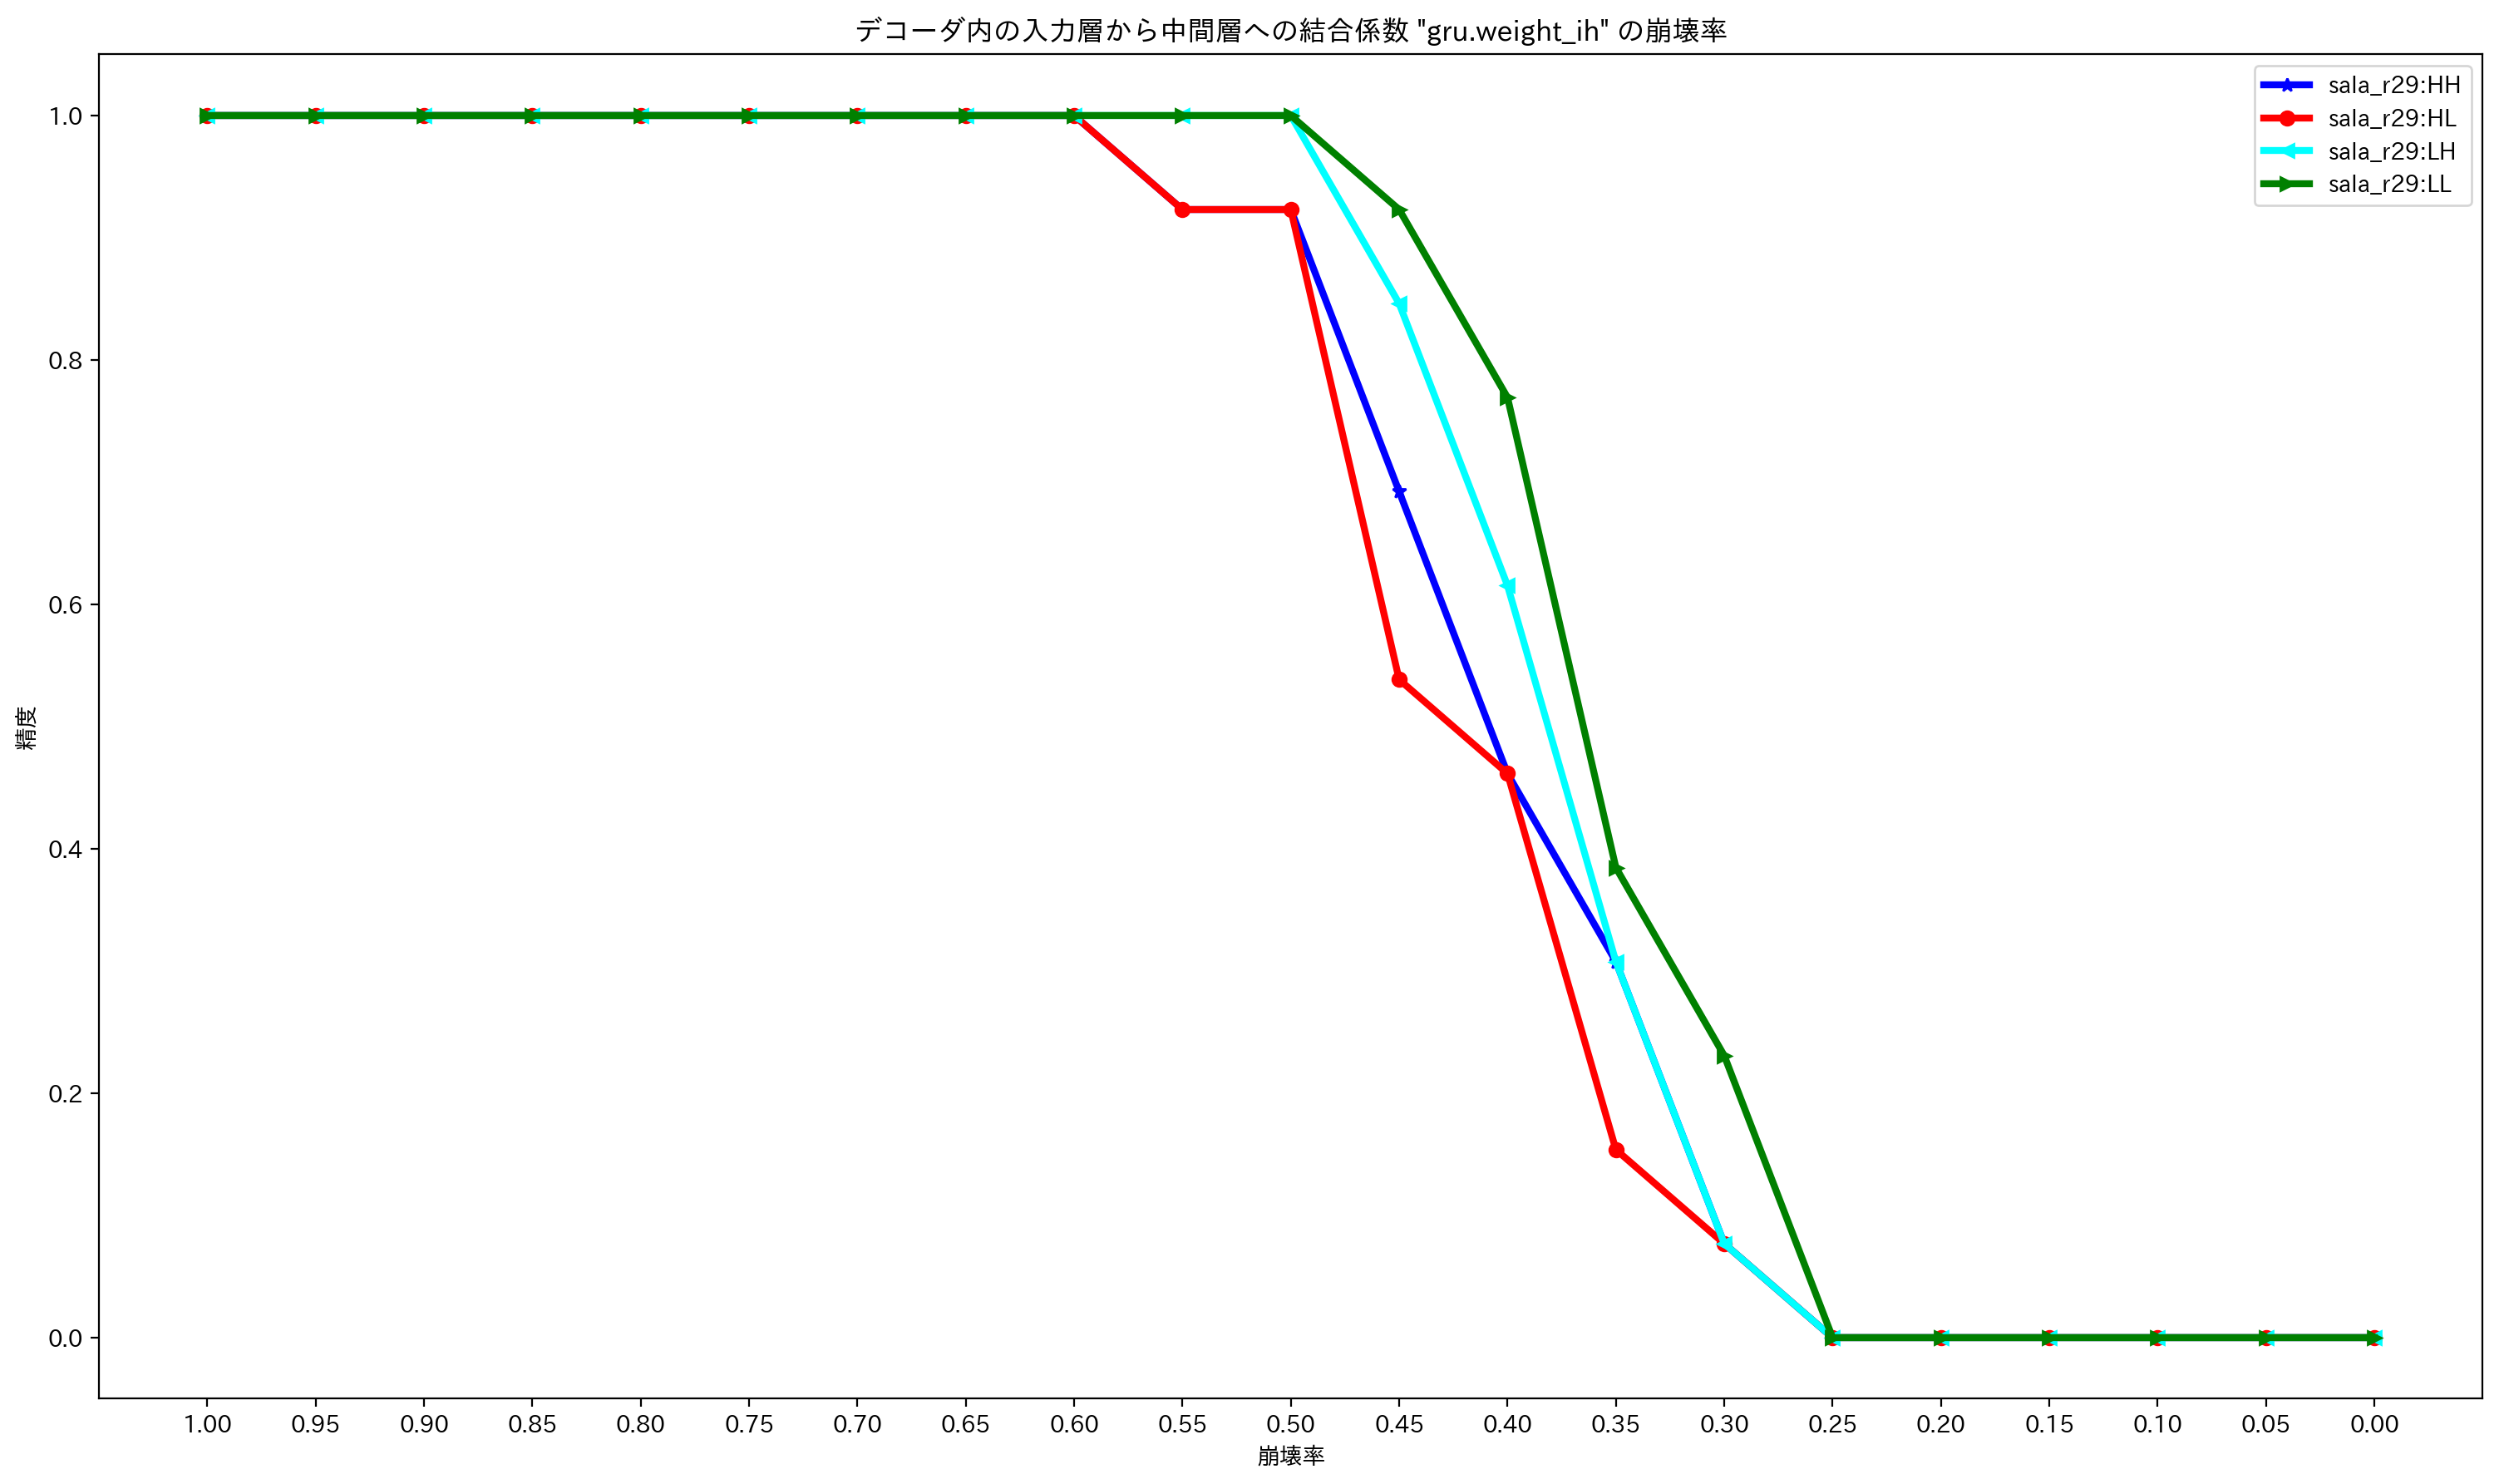

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

x = [k for k,v in sala_results.items()]
y29hh = [v['sala_r29']['HH'] for k,v in sala_results.items()]
y29hl = [v['sala_r29']['HL'] for k,v in sala_results.items()]
y29lh = [v['sala_r29']['LH'] for k,v in sala_results.items()]
y29ll = [v['sala_r29']['LL'] for k,v in sala_results.items()]
y30hira2 = [v['sala_r30']['hira2'] for k,v in sala_results.items()]
y30hira3 = [v['sala_r30']['hira3'] for k,v in sala_results.items()]
y30hira4 = [v['sala_r30']['hira4'] for k,v in sala_results.items()]
y30kata2 = [v['sala_r30']['kata2'] for k,v in sala_results.items()]
y30kata3 = [v['sala_r30']['kata3'] for k,v in sala_results.items()]
y30kata4 = [v['sala_r30']['kata4'] for k,v in sala_results.items()]
y30kanj2 = [v['sala_r30']['kanj2'] for k,v in sala_results.items()]
y30kanj3 = [v['sala_r30']['kanj3'] for k,v in sala_results.items()]
y30kanj4 = [v['sala_r30']['kanj4'] for k,v in sala_results.items()]
y31_2 = [v['sala_r31']['2'] for k,v in sala_results.items()]
y31_3 = [v['sala_r31']['3'] for k,v in sala_results.items()]
y31_4 = [v['sala_r31']['4'] for k,v in sala_results.items()]

plt.plot(x, y29hh, c='blue', label='sala_r29:HH', marker='*', linewidth=3)
plt.plot(x, y29hl, c='red', label='sala_r29:HL', marker='o', linewidth=3) # , linestyle='dashed')
plt.plot(x, y29lh, c='cyan',label='sala_r29:LH', marker='<', linewidth=3)
plt.plot(x, y29ll, c='green',label='sala_r29:LL', marker='>', linewidth=3)
#plt.plot(x, y41, c='green', label='tlpa4非単語', marker='o', linewidth=3, linestyle='dashed')
#plt.plot(x, y20, c='red', label='tlpa2単語', marker='*', linewidth=3)
#plt.plot(x, y21, c='red', label='tlpa2非単語', marker='*', linewidth=3, linestyle='dashed')
plt.xlabel('崩壊率')
plt.ylabel('精度')
#plt.title('中間表象とデコーダとの注意結合の崩壊率')
#plt.title('デコーダの再帰結合の崩壊率')
plt.title('デコーダ内の入力層から中間層への結合係数 "gru.weight_ih" の崩壊率')
plt.legend()
#fig.savefig('2022_0517lam_p2p_gru_weight_ih_sala.pdf', dpi=100)

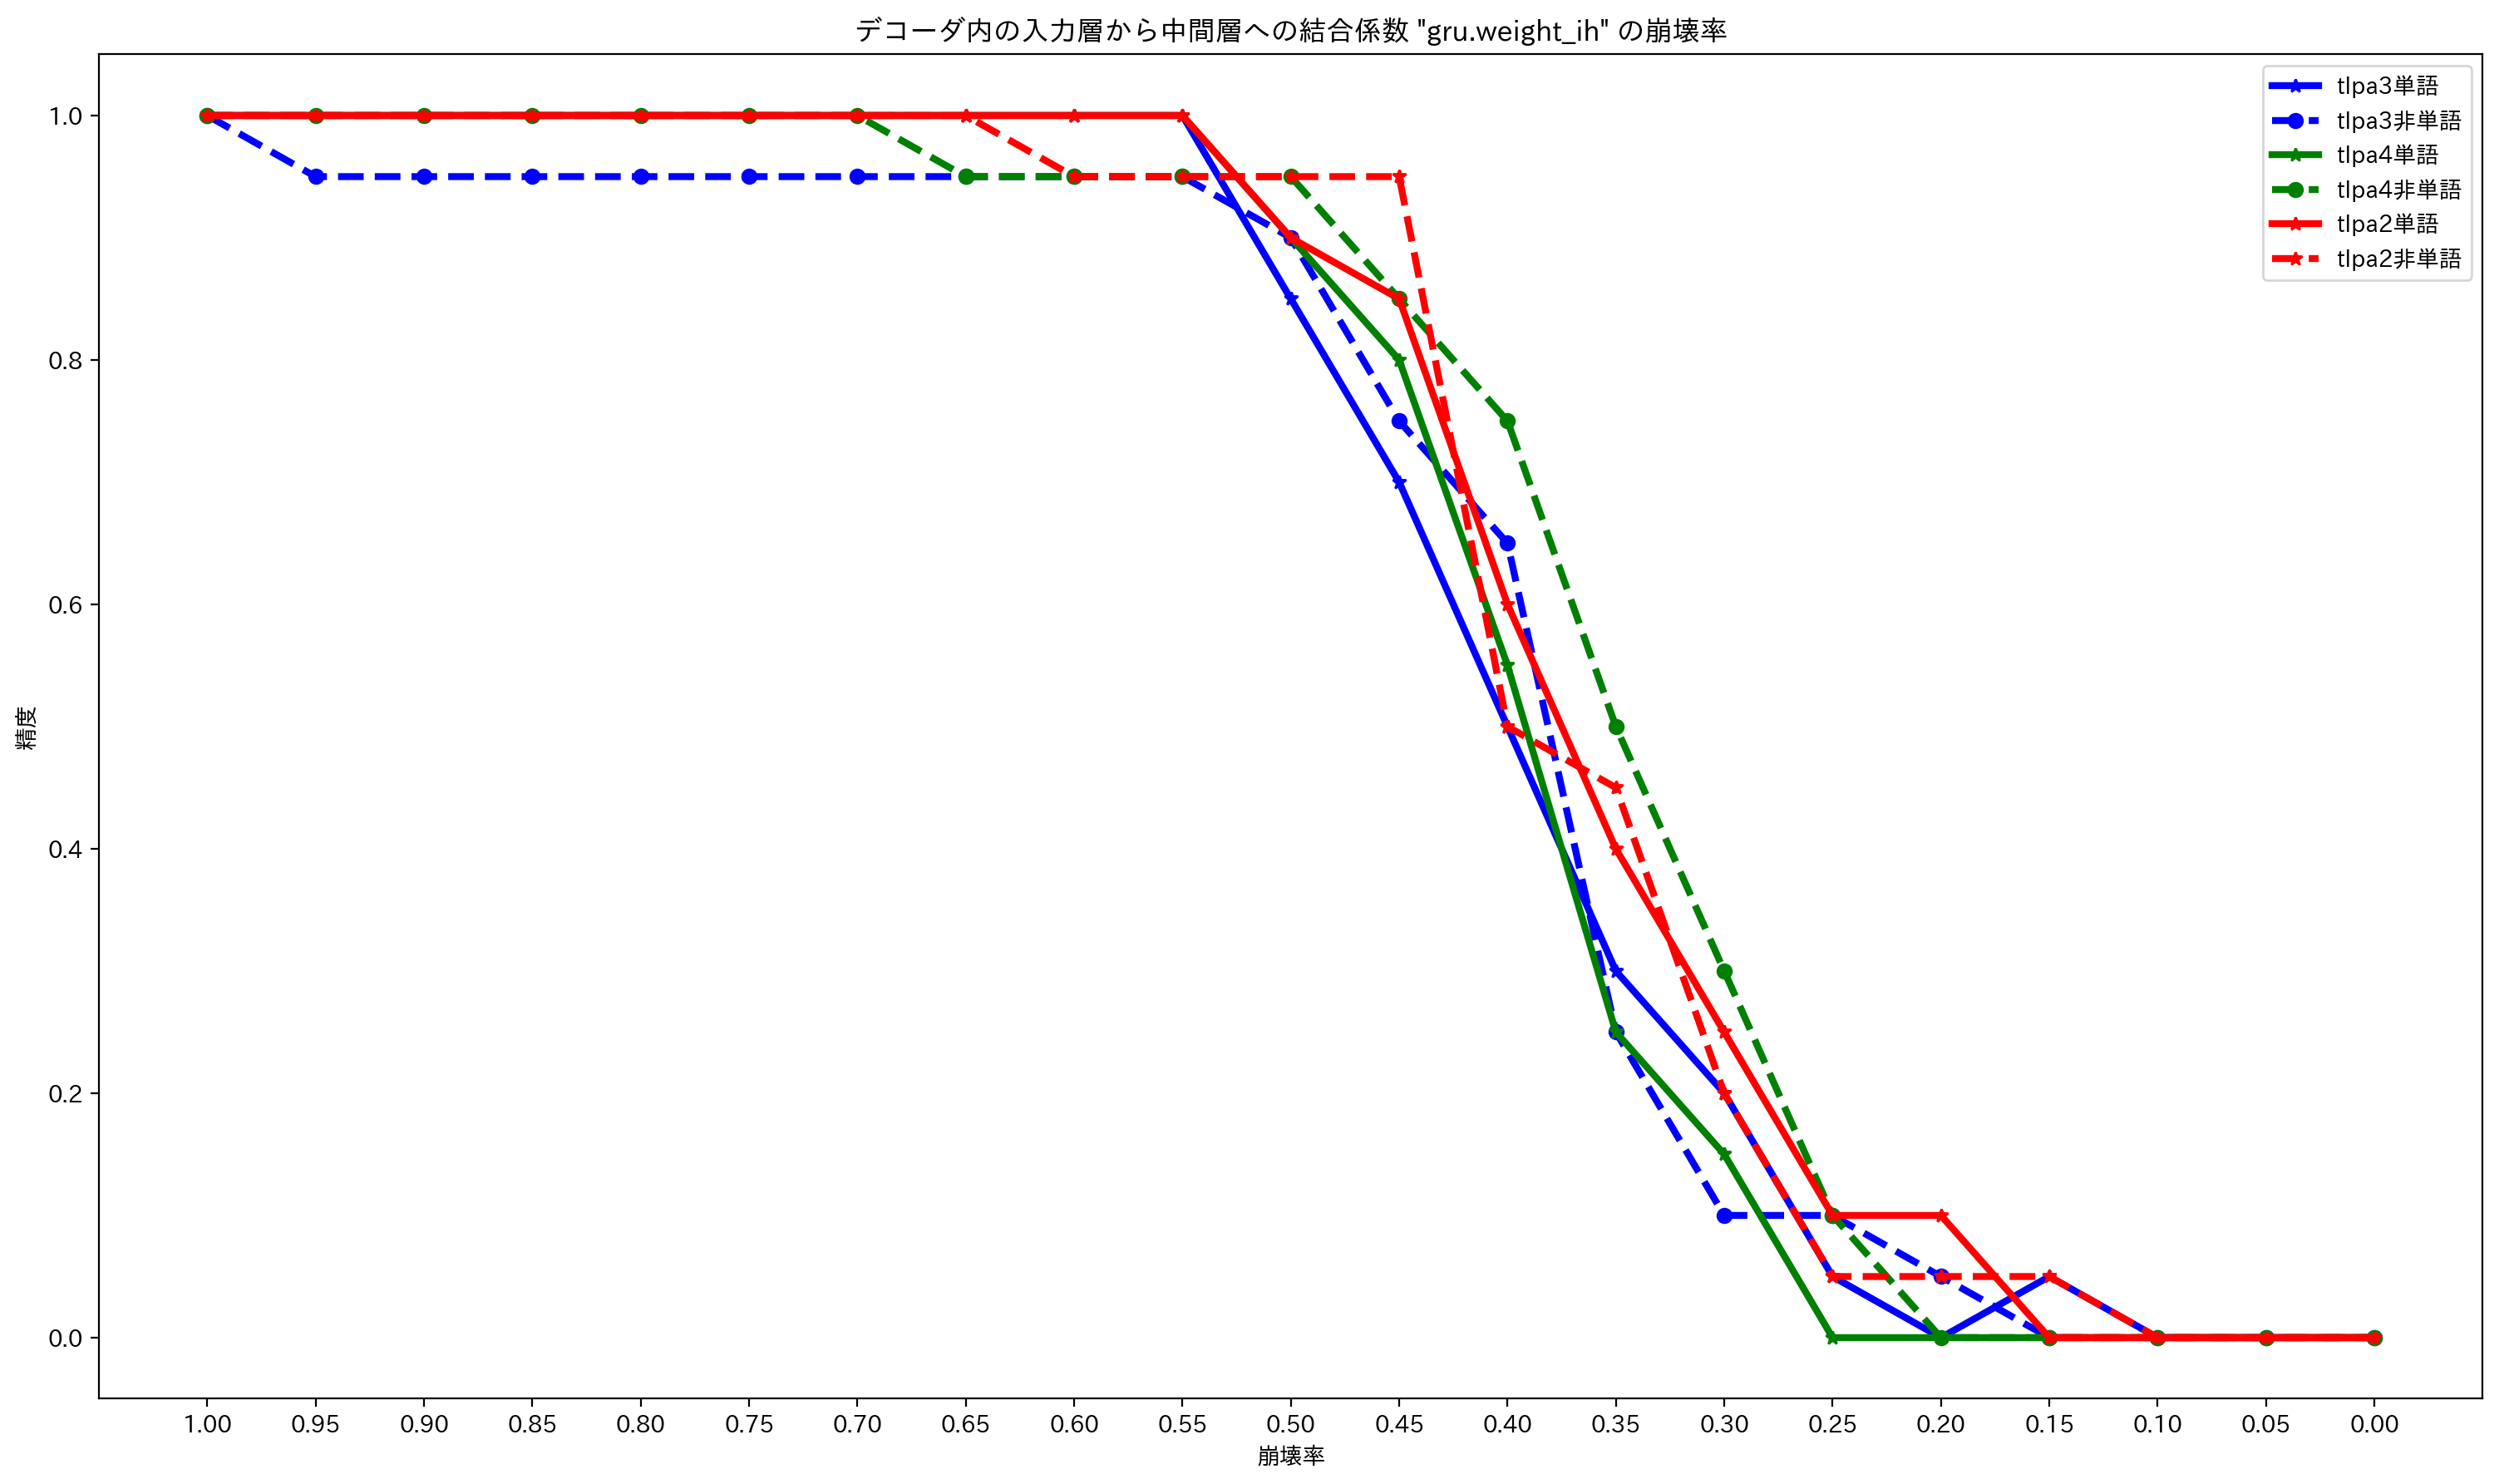

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

x = [k for k,v in tlpa_results.items()]
y20 = [v['tlpa2']['単語'] for k,v in tlpa_results.items()]
y21 = [v['tlpa2']['非単語'] for k,v in tlpa_results.items()]
y30 = [v['tlpa3']['単語'] for k,v in tlpa_results.items()]
y31 = [v['tlpa3']['非単語'] for k,v in tlpa_results.items()]
y40 = [v['tlpa4']['単語'] for k,v in tlpa_results.items()]
y41 = [v['tlpa4']['非単語'] for k,v in tlpa_results.items()]

plt.plot(x,y30, c='blue', label='tlpa3単語', marker='*', linewidth=3)
plt.plot(x,y31, c='blue', label='tlpa3非単語', marker='o', linewidth=3, linestyle='dashed')
plt.plot(x,y40, c='green', label='tlpa4単語', marker='*', linewidth=3)
plt.plot(x,y41, c='green', label='tlpa4非単語', marker='o', linewidth=3, linestyle='dashed')
plt.plot(x,y20, c='red', label='tlpa2単語', marker='*', linewidth=3)
plt.plot(x,y21, c='red', label='tlpa2非単語', marker='*', linewidth=3, linestyle='dashed')
plt.xlabel('崩壊率')
plt.ylabel('精度')
#plt.title('中間表象とデコーダとの注意結合の崩壊率')
#plt.title('デコーダの再帰結合の崩壊率')
plt.title('デコーダ内の入力層から中間層への結合係数 "gru.weight_ih" の崩壊率')
plt.legend()
#fig.savefig('2022_0517lam_p2p_gru_weight_ih.pdf', dpi=100)

In [ ]:
lam.check_vals_performance(encoder, decoder, _dataset=X_vals,
                           source_vocab=source_vocab, target_vocab=target_vocab,
                           max_length=_vocab.max_length)
# lam.check_vals_performance(enc2, dec2, _dataset=X_vals,
#                            source_vocab=source_vocab, target_vocab=target_vocab,
#                            max_length=_vocab.max_length)

In [ ]:
_dataset['tlpa2']['rawdata'] == tlpa2

In [ ]:
def calc_val_tlpa(encoder=encoder,
                  decoder=decoder,
                  _data=X_vals['tlpa2val'],
                  #_data=X_vals['TLPA2'],
                  _cond=tlpa2,
                  source_vocab=source_vocab, 
                  target_vocab=target_vocab,
                  cond=_dataset['tlpa2'],
                  max_length=_vocab.max_length,
                  isPrint:bool=False):
    n_hit = 0 
    n_word, c_word, n_non_word, c_non_word = 0, 0, 0, 0
    for i in range(_data.__len__()):
        _input_ids, _target_ids = _data.__getitem__(i)
        _output_words, _output_ids, _attentions = lam.evaluate(encoder, decoder, 
                                                               _input_ids, max_length=max_length, 
                                                               source_vocab=source_vocab,
                                                               target_vocab=target_vocab)
        _hit = _target_ids == _output_ids
        _cond_NW = len(_cond[f'{i+1:02d}'][1]) > 0
        if _hit:
            if _cond_NW:
                n_non_word += 1 
            else:
                n_word += 1
        if _cond_NW:
            c_word += 1
        else:
            c_non_word += 1

        n_hit += 1 if _hit else 0
        
    if not isPrint:
        return {'単語': n_word/c_word, '非単語': n_non_word/c_non_word } 
    else:
        print(f'単語:{n_word / c_word:.3f}',
              f'非単語:{n_non_word / c_non_word:.3f}')
        

def calc_val_tlpas(encoder=encoder, decoder=decoder,
                   source_vocab=source_vocab,
                   target_vocab=target_vocab,
                   max_length=_vocab.max_length,
                   isPrint:bool=False):
    
    ret_dict = {'tlpa2':{}, 'tlpa3':{}, 'tlpa4':{}}
    for _d in ret_dict.keys():
        if isPrint: print(f'{_d}', end=' ')
        ret_dict[_d] = calc_val_tlpa(encoder=encoder, decoder=decoder, 
                                     _data=eval(_d+'val'), cond=_dataset[_d],
                                     source_vocab=source_vocab, target_vocab=target_vocab,
                                     max_length=_ccap_vocab.max_length, isPrint=isPrint)
    return ret_dict

In [ ]:
X_vals.keys()

In [ ]:
def _calc_val_sala_r29(encoder=encoder, decoder=decoder, _data=X_vals['sala_r29val'], _cond=sala_r29,
                      source_vocab=source_vocab, target_vocab=target_vocab, 
                      cond=_dataset['sala_r29']['rawdata'], max_length=_vocab.max_length):

    ret_conds = {'HH':{}, 'HL':{}, 'LH':{}, 'LL':{}}
    hits  = {'HH':0, 'HL':0, 'LH':0, 'LL':0}
    total = {'HH':0, 'HL':0, 'LH':0, 'LL':0}
    for i in range(_data.__len__()):
        _input_ids, _target_ids = _data.__getitem__(i)
        _output_words, _output_ids, _attentions = lam.evaluate(encoder, decoder, 
                                                               _input_ids, max_length=max_length, 
                                                               source_vocab=source_vocab,
                                                               target_vocab=target_vocab)
        _cond = cond[str(f'{i+1:02d}')][1]
        if   _cond == '1000': __cond = 'HH'
        elif _cond == '0100': __cond = 'HL'
        elif _cond == '0010': __cond = 'LH'
        elif _cond == '0001': __cond = 'LL'
        if _target_ids == _output_ids: hits[__cond] += 1
        total[__cond] += 1
            
    return hits, total


def calc_val_sala_r29(encoder=encoder, decoder=decoder, _data=X_vals['sala_r29val'], _cond=sala_r29,
                      source_vocab=source_vocab, target_vocab=target_vocab, 
                      cond=_dataset['sala_r29']['rawdata'], max_length=_vocab.max_length):

    ret_conds = {'HH':{}, 'HL':{}, 'LH':{}, 'LL':{}}
    hits  = {'HH':0, 'HL':0, 'LH':0, 'LL':0}
    total = {'HH':0, 'HL':0, 'LH':0, 'LL':0}
    for i in range(_data.__len__()):
        _input_ids, _target_ids = _data.__getitem__(i)
        _output_words, _output_ids, _attentions = lam.evaluate(encoder, decoder, _input_ids, max_length=max_length, 
                                                               source_vocab=source_vocab, target_vocab=target_vocab)
        _cond = cond[str(f'{i+1:02d}')][1]
        if   _cond == '1000': __cond = 'HH'
        elif _cond == '0100': __cond = 'HL'
        elif _cond == '0010': __cond = 'LH'
        elif _cond == '0001': __cond = 'LL'
        if _target_ids == _output_ids:
            hits[__cond] += 1
        total[__cond] += 1

    for _ret_cond in ret_conds.keys():
        ret_conds[_ret_cond] = hits[_ret_cond]/total[_ret_cond]
    return ret_conds    
    #return hits, total


def calc_val_sala_r30(encoder=encoder, decoder=decoder, _data=X_vals['sala_r30val'], _cond=sala_r30,
                      source_vocab=source_vocab, target_vocab=target_vocab,
                      cond=_dataset['sala_r30']['rawdata'], max_length=_vocab.max_length):
    
    ret_conds  = {'hira2':{}, 'hira3':{}, 'hira4':{}, 
                  'kata2':{}, 'kata3':{}, 'kata4':{}, 
                  'kanj2':{}, 'kanj3':{}, 'kanj4':{}}
    hits  = {'hira2':0, 'hira3':0, 'hira4':0, 'kata2':0, 'kata3':0, 'kata4':0, 'kanj2':0, 'kanj3':0, 'kanj4':0}
    total = {'hira2':0, 'hira3':0, 'hira4':0, 'kata2':0, 'kata3':0, 'kata4':0, 'kanj2':0, 'kanj3':0, 'kanj4':0}
    for i in range(_data.__len__()):
        _input_ids, _target_ids = _data.__getitem__(i)
        _output_words, _output_ids, _attentions = lam.evaluate(encoder, decoder, _input_ids, max_length=max_length, 
                                                               source_vocab=source_vocab, target_vocab=target_vocab)
        
        num = str(f'{i+1:02d}')
        _stim = cond[num][0]
        _cond_moji = cond[num][1]
        _cond_mora = cond[num][2]
        __cond = _cond_moji+_cond_mora
        _hit = _target_ids == _output_ids
        if _hit: hits[__cond] += 1
        total[__cond] += 1

    for _ret_cond in ret_conds.keys():
        ret_conds[_ret_cond] = hits[_ret_cond]/total[_ret_cond]
    return ret_conds    
    #return hits, total

def _calc_val_sala_r30(encoder=encoder, decoder=decoder, _data=X_vals['sala_r30val'], _cond=sala_r30,
                      source_vocab=source_vocab, target_vocab=target_vocab,
                      cond=_dataset['sala_r30']['rawdata'], max_length=_vocab.max_length):
    
    hits  = {'hira2':0, 'hira3':0, 'hira4':0, 'kata2':0, 'kata3':0, 'kata4':0, 'kanj2':0, 'kanj3':0, 'kanj4':0}
    total = {'hira2':0, 'hira3':0, 'hira4':0, 'kata2':0, 'kata3':0, 'kata4':0, 'kanj2':0, 'kanj3':0, 'kanj4':0}
    for i in range(_data.__len__()):
        _input_ids, _target_ids = _data.__getitem__(i)
        _output_words, _output_ids, _attentions = lam.evaluate(encoder, decoder, _input_ids, max_length=max_length, 
                                                               source_vocab=source_vocab, target_vocab=target_vocab)
        
        num = str(f'{i+1:02d}')
        _stim = cond[num][0]
        _cond_moji = cond[num][1]
        _cond_mora = cond[num][2]
        __cond = _cond_moji+_cond_mora
        _hit = _target_ids == _output_ids
        if _hit: hits[__cond] += 1
        total[__cond] += 1
        
    return hits, total

def calc_val_sala_r31(encoder=encoder, 
                      decoder=decoder,
                      _data=X_vals['sala_r31val'], _cond=sala_r31,
                      source_vocab=source_vocab, target_vocab=target_vocab,
                      cond=_dataset['sala_r31']['rawdata'],
                      max_length=_vocab.max_length):
    
    hits  = {'2':0, '3':0, '4':0, '5':0}
    total  = {'2':0, '3':0, '4':0, '5':0}
    ret_conds  = {'2':{}, '3':{}, '4':{}}
    
    for i in range(_data.__len__()):
        _input_ids, _target_ids = _data.__getitem__(i)
        _output_words, _output_ids, _attentions = lam.evaluate(encoder, decoder, _input_ids, max_length=max_length, 
                                                               source_vocab=source_vocab, target_vocab=target_vocab)
        
        num = str(f'{i+1:02d}')
        __cond = cond[num][1]
        _hit = _target_ids == _output_ids
        if _hit: hits[__cond] += 1
        total[__cond] += 1
        
    for _ret_cond in ret_conds.keys():
        ret_conds[_ret_cond] = hits[_ret_cond]/total[_ret_cond]
    return ret_conds    
    #return hits, total

def _calc_val_sala_r31(encoder=encoder, 
                       decoder=decoder,
                      _data=X_vals['sala_r31val'], _cond=sala_r31,
                      source_vocab=source_vocab, target_vocab=target_vocab,
                      cond=_dataset['sala_r31']['rawdata'],
                      max_length=_vocab.max_length):
    
    hits  = {'2':0, '3':0, '4':0, '5':0}
    total  = {'2':0, '3':0, '4':0, '5':0}
    for i in range(_data.__len__()):
        _input_ids, _target_ids = _data.__getitem__(i)
        _output_words, _output_ids, _attentions = lam.evaluate(encoder, decoder, _input_ids, max_length=max_length, 
                                                               source_vocab=source_vocab, target_vocab=target_vocab)
        
        num = str(f'{i+1:02d}')
        __cond = cond[num][1]
        _hit = _target_ids == _output_ids
        if _hit: hits[__cond] += 1
        total[__cond] += 1
    return hits, total


def calc_val_salas(encoder=encoder, decoder=decoder, source_vocab=source_vocab, target_vocab=target_vocab,
                   max_length=_vocab.max_length, 
                   isPrint=False):
    
    ret_results = {'sala_r29':{}, 'sala_r30':{}, 'sala_r31':{}}
    
    __x            = calc_val_sala_r29(encoder=encoder, decoder=decoder, 
                                       source_vocab=source_vocab, target_vocab=target_vocab, 
                                       max_length=_vocab.max_length)    
    #_hits, _total = _calc_val_sala_r29(encoder=encoder, decoder=decoder, 
    #                                   source_vocab=source_vocab, target_vocab=target_vocab, 
    #                                   max_length=_ccap_vocab.max_length)
    ret_results['sala_r29'] = __x
    #ret_results['sala_r29'] = {'_hits':_hits, '_total':_total}
    if isPrint: 
        print('sala_r29', end=" ")
        print(__x)
        # for h,t in zip(_hits,_total):
        #     print(f'{h}:{_hits[h]/_total[t]:.3f}', end=" ")
        # print()

    __x            = calc_val_sala_r30(encoder=encoder,decoder=decoder, 
                                       source_vocab=source_vocab, target_vocab=target_vocab, 
                                       max_length=_vocab.max_length)
    #_hits, _total = calc_val_sala_r30(encoder=encoder,decoder=decoder, 
    #                                  source_vocab=source_vocab, target_vocab=target_vocab, 
    #                                  max_length=_ccap_vocab.max_length)

    ret_results['sala_r30'] = __x
    #ret_results['sala_r30'] = {'_hits':_hits, '_total':_total}
    if isPrint:
        print('sala_r30', end=" ")
        for h,t in zip(_hits,_total):
            print(f'{h}:{_hits[h]/_total[t]:.3f}', end=" ")
        print()

    __x            = calc_val_sala_r31(encoder=encoder,decoder=decoder, source_vocab=source_vocab, 
                                       target_vocab=target_vocab, max_length=_vocab.max_length)
    #_hits, _total = calc_val_sala_r31(encoder=encoder,decoder=decoder, source_vocab=source_vocab, 
    #                                  target_vocab=target_vocab, max_length=_ccap_vocab.max_length)
    ret_results['sala_r31'] = __x
    #ret_results['sala_r31'] = {'_hits':_hits, '_total':_total}
    if isPrint:
        print('sala_r31', end=" ")
        for h,t in zip(_hits,_total):
            print(f'{h}:{_hits[h]/_total[t]:.3f}', end=" ")
        print()
    else:
        return ret_results


isPrint = False
# print(calc_val_tlpas(encoder=encoder, decoder=decoder, source_vocab=source_vocab, target_vocab=target_vocab,
#                max_length=_ccap_vocab.max_length, isPrint=isPrint))
print(calc_val_salas(encoder=encoder, decoder=decoder, 
                     source_vocab=source_vocab, target_vocab=target_vocab, 
                     max_length=_vocab.max_length, isPrint=isPrint))
#print(calc_val_sala_r29(encoder=encoder, decoder=decoder, 
#                        source_vocab=source_vocab, target_vocab=target_vocab, 
#                        max_length=_ccap_vocab.max_length))
#print(_calc_val_sala_r29(encoder=encoder, decoder=decoder, 
#                         source_vocab=source_vocab, target_vocab=target_vocab, 
#                         max_length=_ccap_vocab.max_length))

#print(calc_val_sala_r30(encoder=encoder, decoder=decoder, 
#                        source_vocab=source_vocab, target_vocab=target_vocab, 
#                        max_length=_ccap_vocab.max_length))
#print(_calc_val_sala_r30(encoder=encoder, decoder=decoder, 
#                         source_vocab=source_vocab, target_vocab=target_vocab, 
#                         max_length=_ccap_vocab.max_length))

#print(calc_val_sala_r31(encoder=encoder, decoder=decoder, 
#                        source_vocab=source_vocab, target_vocab=target_vocab, 
#                        max_length=_ccap_vocab.max_length))
#print(_calc_val_sala_r31(encoder=encoder, decoder=decoder, 
#                         source_vocab=source_vocab, target_vocab=target_vocab, 
#                         max_length=_ccap_vocab.max_length))

In [ ]:
lam.check_vals_performance(encoder, decoder, _dataset=X_vals,
                           source_vocab=source_vocab, target_vocab=target_vocab,
                           max_length=_vocab.max_length
                          )
#print(X_vals['TLPA2'].__len__())
#print(_dataset['tlpa2']['pdata'].keys())

In [ ]:
def check_vals_performance(encoder=None, decoder=None, 
                           _dataset=None, 
                           max_length=0, 
                           source_vocab=None,
                           target_vocab=None,
                           ):
    if _dataset == None or encoder == None or decoder == None or max_length == 0 or source_vocab == None:
        return
    print('検証データ:',end="")
    for _x in _dataset:
        ok_count = 0 
        for i in range(_dataset[_x].__len__()):
            _input_ids, _target_ids = _dataset[_x].__getitem__(i)
            _output_words, _output_ids, _attentions = evaluate(encoder, decoder, _input_ids, 
                                                               max_length, 
                                                               source_vocab=source_vocab,
                                                               target_vocab=target_vocab
                                                               )
            ok_count += 1 if _target_ids == _output_ids else 0
        print(f'{_x}:{ok_count/_dataset[_x].__len__():.3f},',end="")
    print()



# 9 エンコーダの内部表現の取得

In [ ]:
def get_an_encoder_representation(encoder:torch.nn.Module,
                                  input_ids:list,
                                  max_length:int=_vocab.max_length)->(list,torch.LongTensor):

    with torch.no_grad():
        input_tensor = convert_ids2tensor(input_ids)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(max_length, encoder.n_hid, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        return encoder_hidden

In [ ]:
X = np.zeros((val_dataset.__len__(), params['hidden_size']))
for i in range(val_dataset.__len__()):
    x = get_an_encoder_representation(encoder, input_ids = val_dataset.__getitem__(i)[0])
    X[i] = x.squeeze(0).clone().detach().numpy()[0]

print(X.shape)

In [ ]:
X[0] == X[1]
#val_dataset.__getitem__(1)

In [ ]:
import ccap.tsne as tsne

tsne_result = tsne.tsne(X)

In [ ]:
import matplotlib.pyplot as plt
import japanize_matplotlib

def plot_tsne(ax, R, wordlist, title=""):
    #tsne = TSNE()
    tsne_result = TSNE(n_components=2).fit_transform(R)
    print(tsne_result.shape)
    tsne1, tsne2 = tsne_result[:,0], tsne_result[:,1]
    ax_scatter_gram(ax, tsne1, tsne2, wordlist, title=title, x_label="tSNE 1", y_label="tSNE 2")
    ###plot_pca(ax, Onmtp_w2v, onmtp_list, title='オノマトペ附置 (PCA)')
    fig, ax = plt.subplots(figsize=(12,13))         # Sample figsize in inches
    plot_pca(ax, R_sala, sala.labels, title='(PCA)')
    plt.show()
    fig, ax = plt.subplots(figsize=(12,13))         # Sample figsize in inches\n",
    plot_tsne(ax, R_sala, sala.labels, title='onomatopea (tSNE)')
    plt.show()

    
fig, ax = plt.subplots(figsize=(8,8))         # Sample figsize in inches
#fig, ax = plt.subplots(figsize=(18,18))         # Sample figsize in inches
tsne1, tsne2 = tsne_result[:,0], tsne_result[:,1]
ax.scatter(tsne1, tsne2, s=20, color='cyan')

#tlpa_romaji = ["".join(_vocab.test_data[x]['phone']) for x in _vocab.test_data]
#for i, label in enumerate(tlpa_romaji):
#for i, label in enumerate(tlpa.test_vocab):
for i, label in enumerate([val_dataset.data[k]['orig'] for k in val_dataset.data.keys()]):
    ax.annotate(label, (tsne1[i], tsne2[i]),fontsize=10)
ax.set_xlabel('tSNE1')
ax.set_ylabel('tSNE2')
ax.set_title('mora_r2mora リカレントニューラルネットワーク自己符号化モデルのエンコーダによる sala 音素の布置 tSNE') 
#plt.savefig(params['path_graph'])
plt.show()

# 10 内部表現の描画

In [ ]:
print(dir(val_dataset.source_vocab))

In [ ]:
type(X_vals['tlpa2val'])
#type(X_vals['sala_r29val'])

In [ ]:
print([(k,type(_dataset[k])) for k in _dataset.keys()])
print([(k,type(X_vals[k])) for k in X_vals.keys()])
#_dataset['tlpa2']

In [ ]:
print(_dataset['tlpa2'].keys())
#print(_dataset['tlpa2']['rawdata']) #['Cond'])
#print(_dataset['sala_r31']) # ['Cond'].keys())
#type(X_vals['TLPA2'])
type(X_vals['sala_r29val'])

In [ ]:
[val_dataset.data[k]['orig'] for k in val_dataset.data.keys()]